# In this file we test all NFT functions from nft_analyse.py

## Import

In [1]:
import sys
# adding signal_handling to the system path
sys.path.insert(0, '../signal_handling/')
sys.path.insert(0, '../nft_handling/')
sys.path.insert(0, '../PJTpy/')

from FNFTpy import nsev#, nsev_poly
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload

import ssfm
reload(ssfm)

import signal_generation as sg
reload(sg)

import nft_analyse as nft
reload(nft)

import test_signals
reload(test_signals)
from PJTpy import pjt

## Create signal

1 [-0.-0.05j]


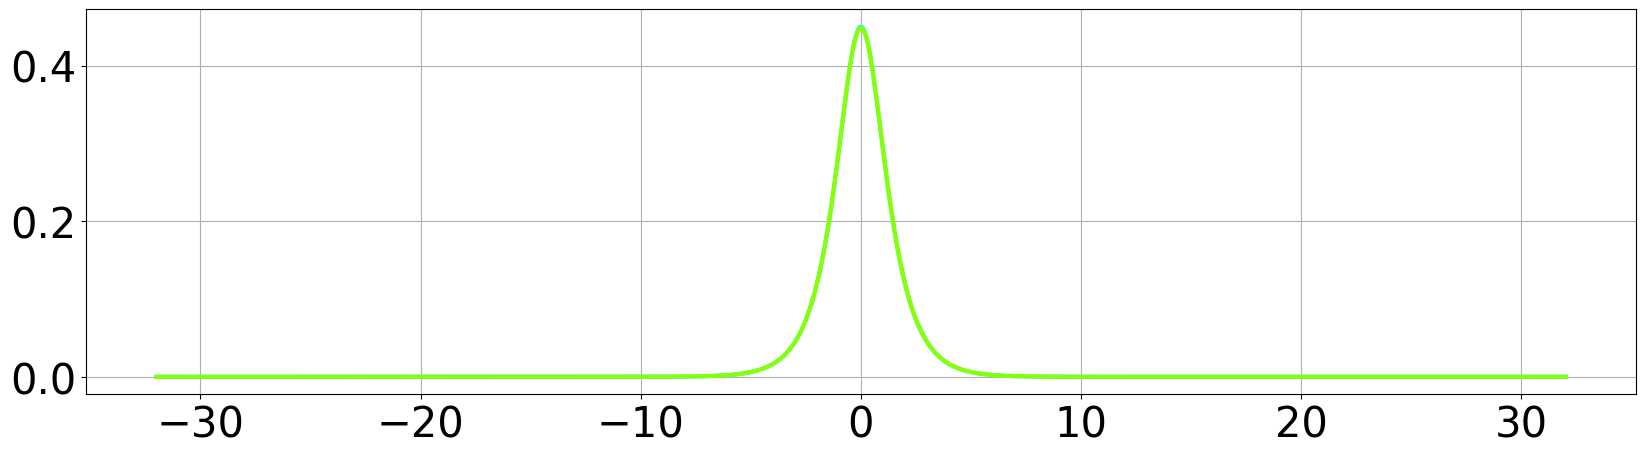

In [171]:
ampl = 0.45
chirp = 0.0

t_span = 64.0
n_t = 2 ** 11

dt = t_span / (n_t - 1)
t = np.array([i * dt - t_span / 2. for i in range(n_t)])

xi_span = np.pi / dt
n_xi = n_t # 2 ** 8
d_xi = xi_span / (n_xi - 1)
xi = np.array([i * d_xi - xi_span / 2. for i in range(n_xi)])

q, a_xi, b_xi, xi_discr, b_discr, r_discr, ad_discr = test_signals.get_sech(t, xi, a=ampl, c=chirp)
print(len(xi_discr), xi_discr)
z_prop = 0.1
q_prop = ssfm.fiber_propagate(q, t_span, z_prop, n_span=2 ** 9, gamma=1, beta2=-1)

matplotlib.rcParams.update({'font.size': 30})
# color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(t, np.absolute(q), 'xkcd:cyan', linewidth=3)
axs.plot(t, np.absolute(q_prop), 'xkcd:lime green', linewidth=3)
axs.grid(True)

# print(b_xi)

2046
(-0.03180897882487037-4.2729162207592613e-14j) (-0.03190871324364755-4.2626147577508165e-14j)


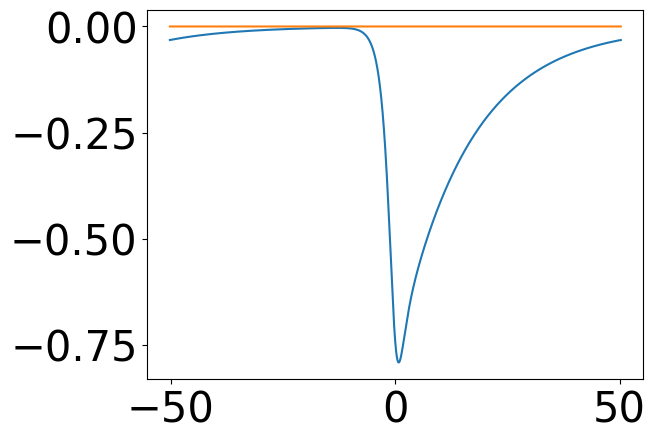

In [172]:
from scipy.signal import hilbert

result_cont = nft.get_continuous_spectrum(q, t, xi=None, type='fnft', xi_upsampling=1, fnft_type=0, nft_type='bo', res_poly=None, coefficient_type='left')

a = result_cont['a']
b = result_cont['b']
r = b / a
omega_r = fftshift(fft(r[:-2])) / np.sqrt(n_t - 2)
print(len(omega_r))

for i in range(len(omega_r)):
    if not i % 2:
        omega_r[i] = - omega_r[i]

omega_r = np.append(omega_r[0], omega_r)
omega_r = np.append(omega_r, omega_r[-1])
#omega_r = np.append(omega_r, omega_r[-1])
print(omega_r[0], omega_r[-1])
#plt.plot(xi, r.real)
#plt.plot(xi, r.imag)
plt.plot(xi, (omega_r.real))
plt.plot(xi, (omega_r.imag))
#plt.plot(xi, np.abs(omega_r))

## WITHOUT PROPAGATION

In [192]:
import nft_analyse as nft
reload(nft)

xi_upsampling = 1
forward_continuous_type='fnft'
forward_discrete_type='pjt' # 'fnft' 'pjt'
forward_discrete_coef_type='bi-direct'
inverse_type='both'
fnft_type=0 # 0 = MOD_AL, 5 = 2SPLIT2B, 21 = 4SPLIT4B, 27 = TES4
nft_type='bo'
use_contour = False
n_discrete_skip = 2

res_dbp = nft.make_dbp_nft(q, t, 0, xi_upsampling=xi_upsampling,
                           forward_continuous_type=forward_continuous_type,
                           forward_discrete_type=forward_discrete_type,
                           forward_discrete_coef_type=forward_discrete_coef_type,
                           inverse_type=inverse_type,
                           fnft_type=fnft_type, nft_type=nft_type,
                           use_contour=use_contour, n_discrete_skip=n_discrete_skip,
                           print_sys_message=True)

q_tib_total = res_dbp['q_total']
q_tib_left = res_dbp['q_tib_left']
q_tib_right = res_dbp['q_tib_right']
q_fnft = res_dbp['q_fnft']

xi_d_calculated = res_dbp['xi_d']
print(xi_d_calculated)
print(xi_discr)
print(res_dbp['bd_prop'])
print("b_prop =", res_dbp['b_prop'][int(n_t/2)])
print("q_tib_total=", q_tib_total[int(n_t/2)])
print("q_fnft=", q_fnft[int(n_t/2)])


# for fnft len(xi) == len(q)
res = nsev_inverse(xi, t, b_xi, xi_discr, b_discr / ad_discr, cst=1, dst=0, dis=fnft_type)
q_fnft_still = res['q']

print(np.shape(b_xi), np.shape(xi))

Time to calculate discrete spectrum 2.0010000000000003 ms
Number of discrete eigenvalues: 0
Time to calculate continuous part of Omega 223.001 ms
Time to calculate discrete part of Omega 0.0 ms
Time to calculate TIB 88.99799999999999 ms
Time to calculate continuous part of Omega 218.999 ms
Time to calculate discrete part of Omega 0.0 ms
Time to calculate TIB 26.0 ms
Time to calculate all TIBs 557.998 ms
Time to calculate inverse FNFT 25.000999999999998 ms
[]
[-0.-0.05j]
[]
b_prop = (-0.9760632688325231+5.5764854539619435e-14j)
q_tib_total= (0.44777838493057137-1.678041456513345e-14j)
q_fnft= (0.44994501889607424+2.317838855390142e-14j)
(2048,) (2048,)


C:\ProgramData\Anaconda3\envs\tensorflow_2_9\lib\site-packages\fnftpy-0.3.0-py3.9.egg\FNFTpy\auxiliary.py:158: UserWarning: An error occured when calling FNFT: error code 7


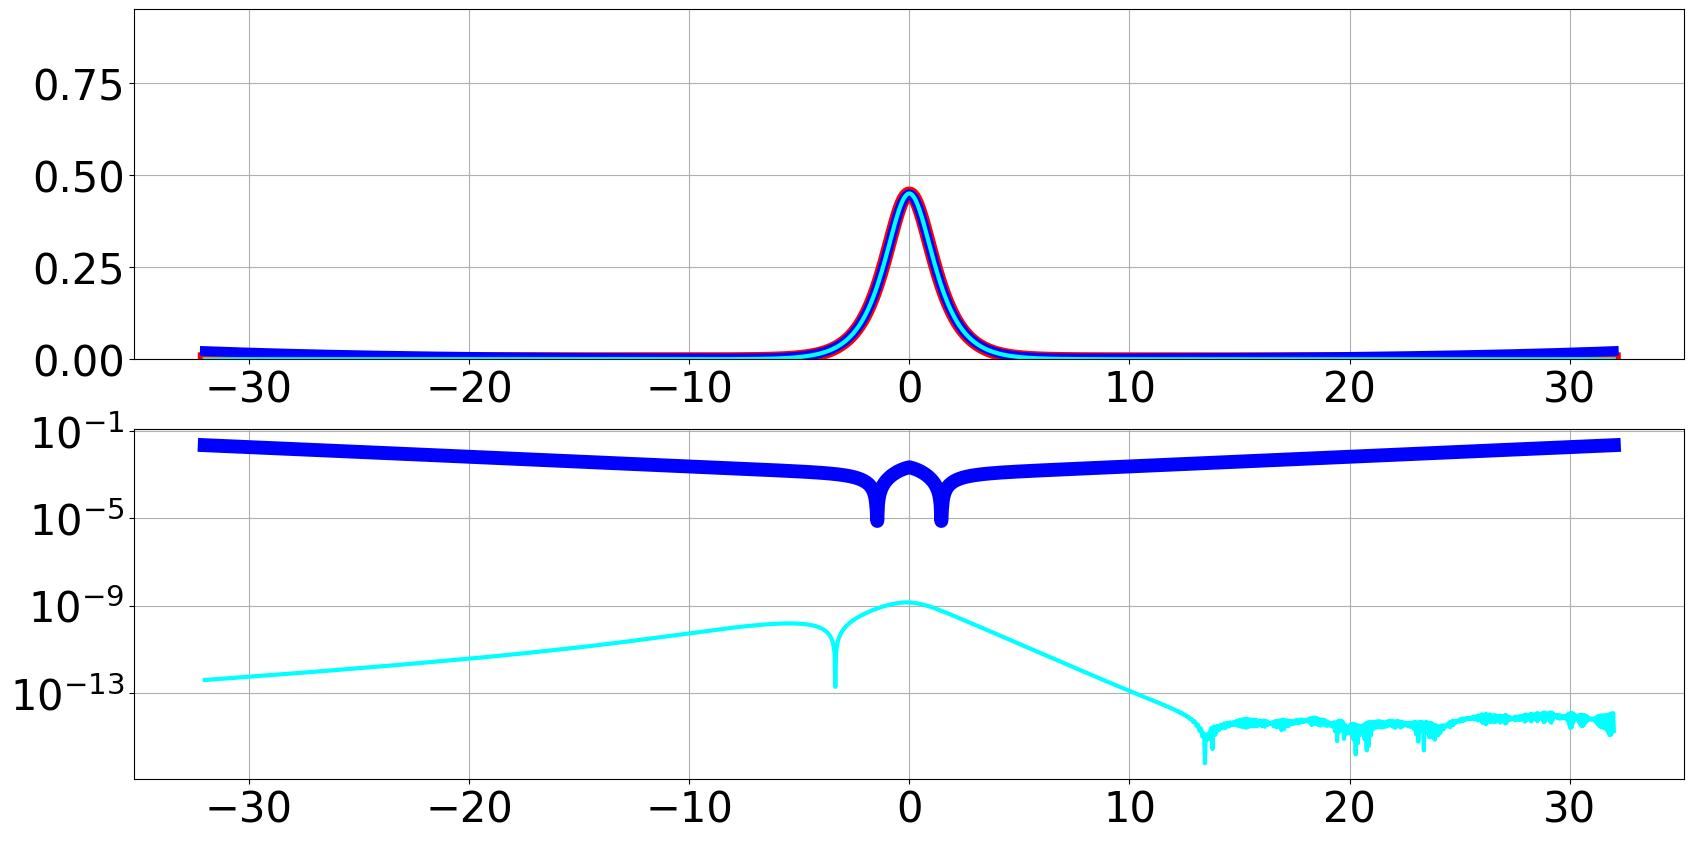

In [196]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan', 'xkcd:lime green']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, np.absolute(q), color[0], linewidth=10)
axs[0].plot(t, np.absolute(q_tib_total), color[1], linewidth=7)
#axs[0].plot(t, np.absolute(q_tib_left), color[2], linewidth=5)
#axs[0].plot(t, np.absolute(q_tib_right), color[3], linewidth=3)
axs[0].plot(t, np.absolute(q_fnft), color[4], linewidth=3)
#axs[0].plot(t, np.absolute(q_fnft_still), color[5], linewidth=3)
axs[0].grid(True)
#axs[0].set_xlim(-15, 15)
axs[0].set_ylim(0, ampl + 0.5)

axs[1].plot(t, np.absolute(q - q_tib_total), color[1], linewidth=10)
#axs[1].plot(t, np.absolute(q - q_tib_left), color[2], linewidth=3)
#axs[1].plot(t, np.absolute(q - q_tib_right), color[3], linewidth=3)
axs[1].plot(t, np.absolute(q - q_fnft), color[4], linewidth=3)
#axs[1].plot(t, np.absolute(q - q_fnft_still), color[5], linewidth=3)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

## WITH PROPAGATION

In [197]:
import nft_analyse as nft
reload(nft)

z_back = z_prop
xi_upsampling = 1
forward_continuous_type='fnft'
forward_discrete_type='pjt' # 'fnft'
forward_discrete_coef_type='bi-direct'
inverse_type='both'
fnft_type=0
nft_type='bo'
use_contour = False
n_discrete_skip = 2

res_dbp = nft.make_dbp_nft(q_prop, t, z_back, xi_upsampling=xi_upsampling,
                           forward_continuous_type=forward_continuous_type,
                           forward_discrete_type=forward_discrete_type,
                           forward_discrete_coef_type=forward_discrete_coef_type,
                           inverse_type=inverse_type,
                           fnft_type=fnft_type, nft_type=nft_type,
                           use_contour=use_contour, n_discrete_skip=n_discrete_skip,
                           print_sys_message=True)

q_tib_total = res_dbp['q_total']
q_tib_left = res_dbp['q_tib_left']
q_tib_right = res_dbp['q_tib_right']
q_fnft = res_dbp['q_fnft']

xi_d_calculated = res_dbp['xi_d']
print(xi_d_calculated)
print(xi_discr)




# for fnft len(xi) == len(q)
res = nsev_inverse(xi, t, b_xi, xi_discr, b_discr / ad_discr, cst=1, dst=0, dis=fnft_type)
q_fnft_still = res['q']

print(np.shape(b_xi), np.shape(xi))

Time to calculate discrete spectrum 0.9990000000000001 ms
Number of discrete eigenvalues: 0
Time to calculate continuous part of Omega 219.0 ms
Time to calculate discrete part of Omega 0.0 ms
Time to calculate TIB 91.0 ms
Time to calculate continuous part of Omega 222.0 ms
Time to calculate discrete part of Omega 0.0 ms
Time to calculate TIB 26.0 ms
Time to calculate all TIBs 558.0 ms
Time to calculate inverse FNFT 25.0 ms
[]
[-0.-0.05j]
(2048,) (2048,)


C:\ProgramData\Anaconda3\envs\tensorflow_2_9\lib\site-packages\fnftpy-0.3.0-py3.9.egg\FNFTpy\auxiliary.py:158: UserWarning: An error occured when calling FNFT: error code 7


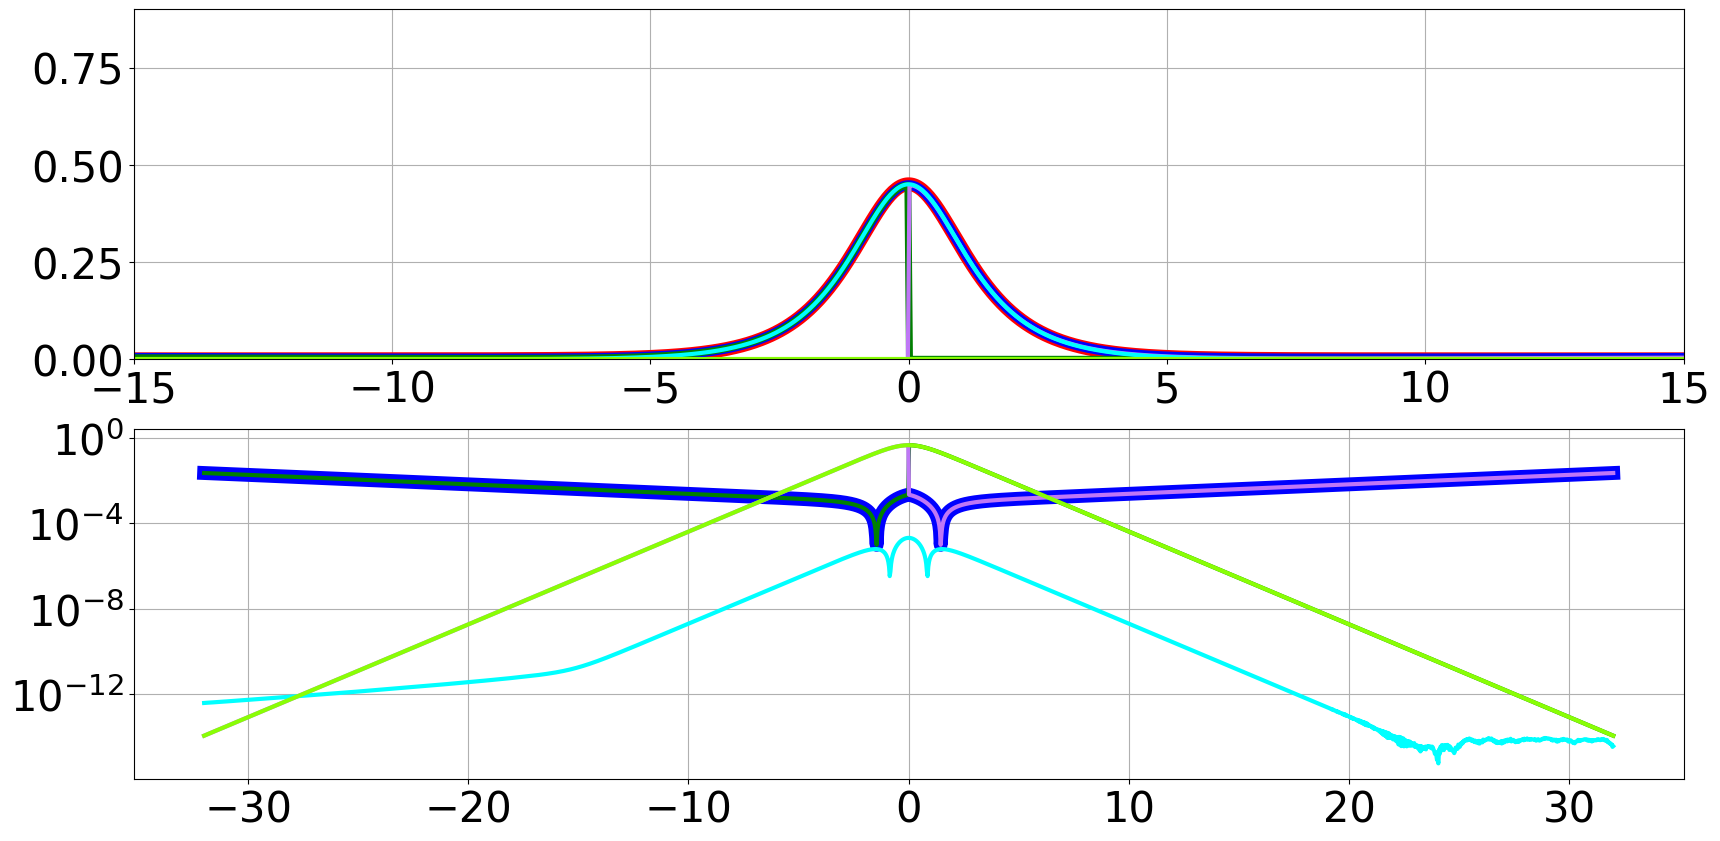

In [198]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan', 'xkcd:lime green']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, np.absolute(q), color[0], linewidth=10)
axs[0].plot(t, np.absolute(q_tib_total), color[1], linewidth=7)
axs[0].plot(t, np.absolute(q_tib_left), color[2], linewidth=5)
axs[0].plot(t, np.absolute(q_tib_right), color[3], linewidth=3)
axs[0].plot(t, np.absolute(q_fnft), color[4], linewidth=3)
axs[0].plot(t, np.absolute(q_fnft_still), color[5], linewidth=3)
axs[0].grid(True)
axs[0].set_xlim(-15, 15)
axs[0].set_ylim(0, 2*ampl)

axs[1].plot(t, np.absolute(q - q_tib_total), color[1], linewidth=10)
axs[1].plot(t, np.absolute(q - q_tib_left), color[2], linewidth=3)
axs[1].plot(t, np.absolute(q - q_tib_right), color[3], linewidth=3)
axs[1].plot(t, np.absolute(q - q_fnft), color[4], linewidth=3)
axs[1].plot(t, np.absolute(q - q_fnft_still), color[5], linewidth=3)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

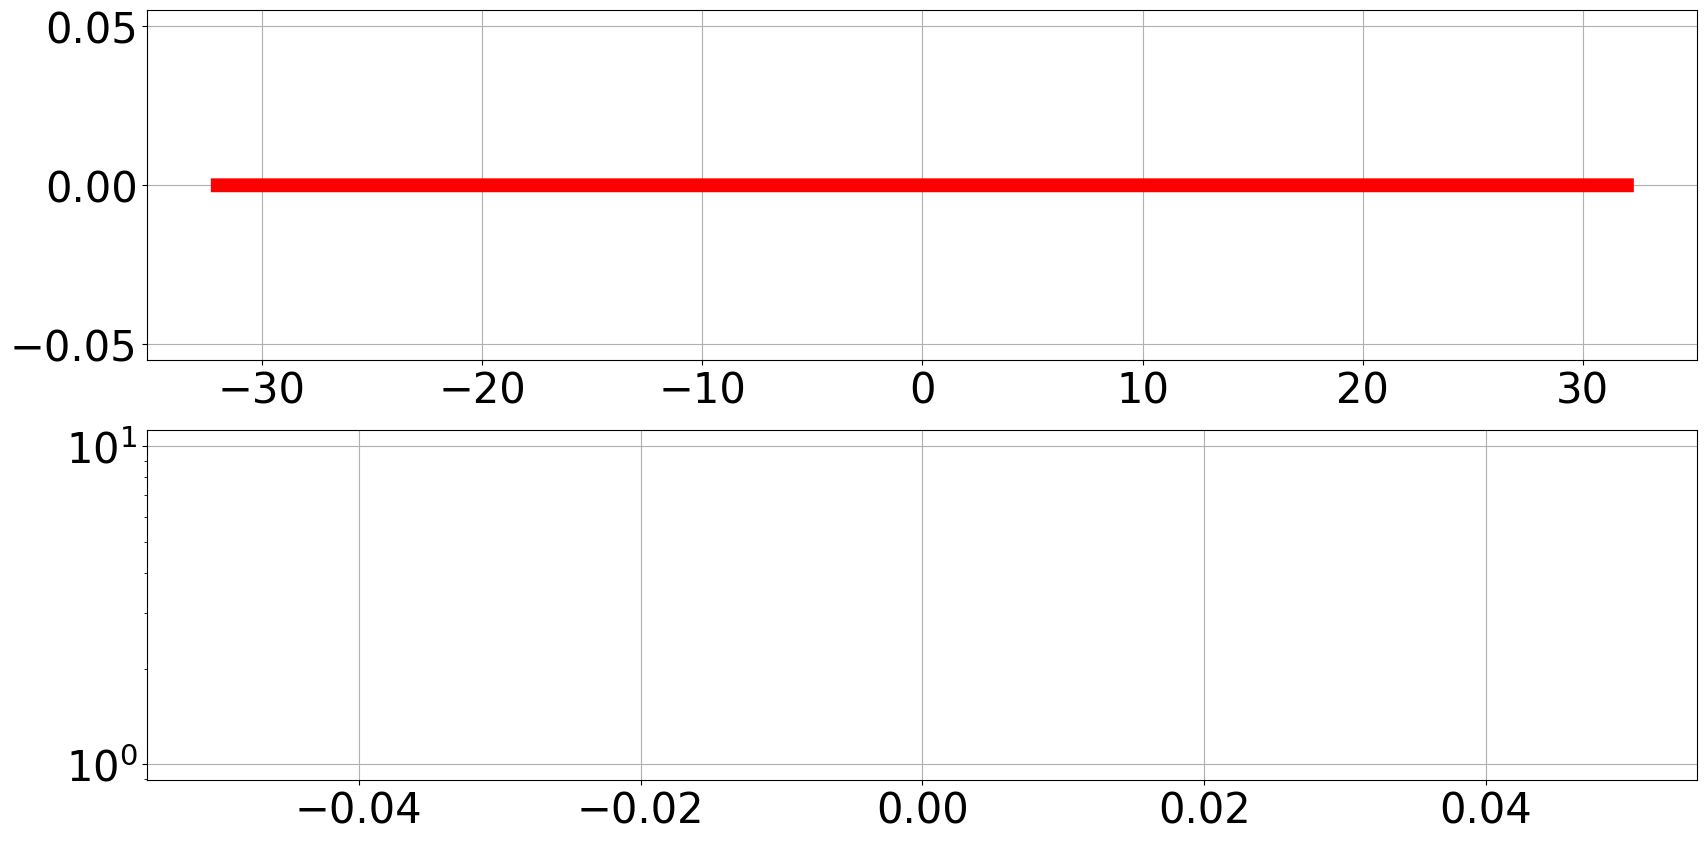

In [50]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, np.absolute(res_dbp['b_prop']), color[0], linewidth=10)
axs[0].plot(t, np.absolute(b_xi), color[1], linewidth=7)
axs[0].grid(True)
# axs[0].set_xlim(-5, 5)
# axs[0].set_ylim(0, ampl + 0.5)

axs[1].plot(t, np.absolute(res_dbp['b_prop'] - b_xi), color[1], linewidth=10)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

## Test bi-directional for arbitrary spectral parameter

In [56]:
reload(nft)
contour_ampl = 0.1
xi_span_test = 2
n_xi_test = 2 ** 7
xi_test = nft.get_raised_contour(contour_ampl, xi_span_test, n_xi_test)

a_test, b_test = nft.do_bi_direct_arbitrary_array(q, t, xi_test, 'tes4')
b_xi_test = test_signals.get_sech_b_coef(xi_test, ampl, chirp)



In [29]:
print(xi_discr)
print(nft.do_bi_direct_arbitrary(q, t, xi_discr[0], 'tes4'))

[0.+1.4993749j 0.+0.4993749j]
((5.5508636205285225e-08-4.334753515793568e-18j), (-0.9982872214516879+0.044181522832452066j))


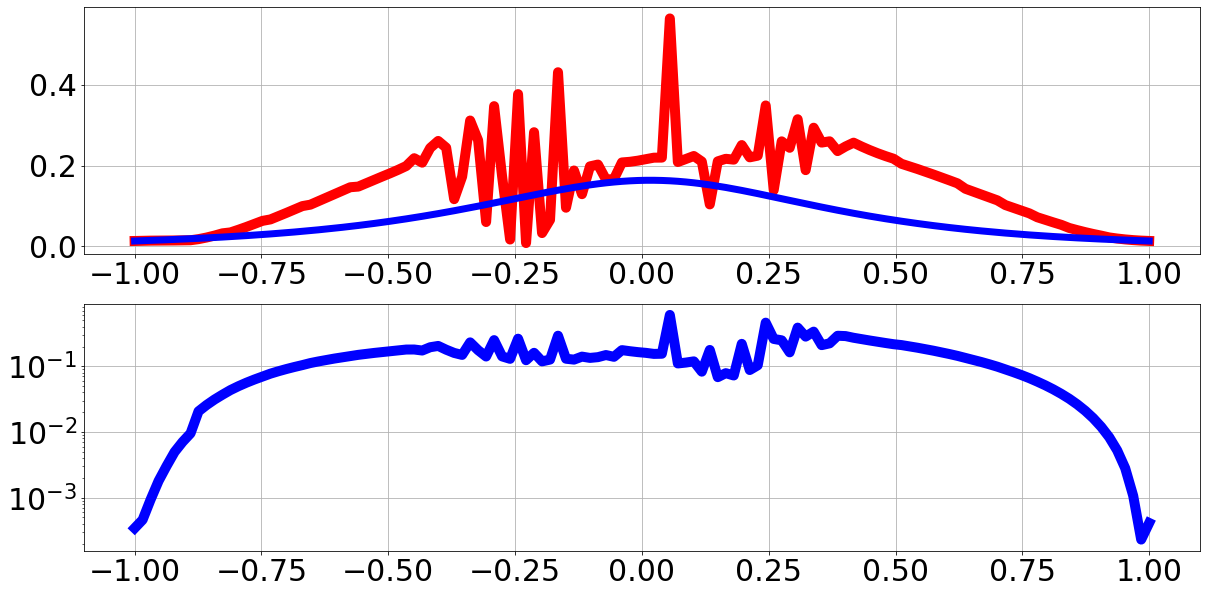

In [57]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(np.real(xi_test), np.absolute(b_test), color[0], linewidth=10)
axs[0].plot(np.real(xi_test), np.absolute(b_xi_test), color[1], linewidth=7)
axs[0].grid(True)
# axs[0].set_xlim(-5, 5)
# axs[0].set_ylim(0, ampl + 0.5)

axs[1].plot(np.real(xi_test), np.absolute(b_test - b_xi_test), color[1], linewidth=10)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())